In [34]:
#Amount google driv
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA

Mounted at /content/gdrive
['data', 'figures', 'models', 'utils']


# Very Small Auto Encoder Pytorch Implementation for MNSIT

## Expermimental Set Up
The model we chosse is quite simple. We are using only linear layers with the ReLU activation function.

In [ ]:
config = {
    'model_name': 'VerySmall-AE',
    'dataset': 'fMNIST',
    # Variance and Mean for the weight initialization
    'seed': 3,
    # Model setup
    'input_dim': 784,
    # Training setup
    'batch_size': 128,
    'num_epochs': 10,
    'learning_rate': 0.001,
}

# DEVICE for Mac for Windows use CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")
# Set the seed
torch.manual_seed(config['seed'])

NameError: name 'torch' is not defined

## Load Dataset
We agreed using the MNSIT dataset first. The code is loaded from the helper folder

In [ ]:
import os
from utils.dataloaders.full_dataloaders import DataLoaderMNIST

# Data Transformations
transformations = [transforms.ToTensor(),
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,))
                                ]
# Create DataLoader
batch_size = config['batch_size']
dataloader = DataLoaderMNIST(batch_size=batch_size, transformation=transformations)

test_loader = dataloader.get_test_loader()
train_loader = dataloader.get_train_loader()

print(len(train_loader), len(test_loader))

469 79


## Inisghts in the data
Always good to take a climpse at data before starting

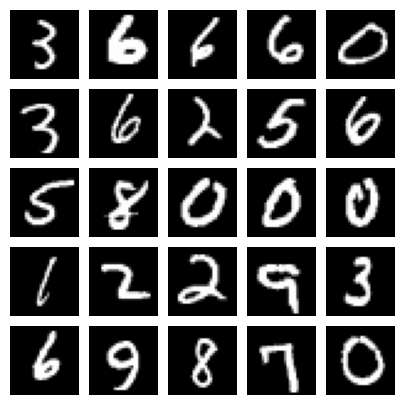

In [ ]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)
# Change the shape of the image (Flatten to 2D)
image_org = image[0].view(-1, 1, 28, 28)

num_samples = 25
sample_images = [image_org[i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

## Model VAE  


In [ ]:
#!pip install lightning

In [ ]:
# Model comes from python file for later usage
from models.definitions.ae_latentdim10 import VerySmallAutoencoder
model = VerySmallAutoencoder()
model = model.to(DEVICE)

## Training Loop


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=config['learning_rate'])

for epoch in range(config['num_epochs']):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #x = x.view(config['batch_size'], config['input_dim'])
        x = x.to(DEVICE)

        optimizer.zero_grad()
        loss = model.training_step(x)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


	Epoch 1 complete! 	Average Loss:  0.007067353234817393
	Epoch 2 complete! 	Average Loss:  0.0067576122933871345
	Epoch 3 complete! 	Average Loss:  0.006728195439045055
	Epoch 4 complete! 	Average Loss:  0.006712773963052811
	Epoch 5 complete! 	Average Loss:  0.006702563312485751
	Epoch 6 complete! 	Average Loss:  0.006694710942813092
	Epoch 7 complete! 	Average Loss:  0.00668827930970802
	Epoch 8 complete! 	Average Loss:  0.006683038821260835
	Epoch 9 complete! 	Average Loss:  0.006678682033561616
	Epoch 10 complete! 	Average Loss:  0.006675005454617815
Finish!!


## Save the model
In this case we are using the follwing name convention Dataset_ModelName_Seed_Epochs.

In [ ]:
# Save the model
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '.pth'
print(name)
# Model Pathb
path = './models/checkpoints/VerySmallAE/MNIST/' + name

torch.save(model.state_dict(), path)

MNIST_VerySmall-AE_3_10.pth


In [ ]:
#Load model
# Model comes from python file for later usage
from models.definitions.ae_latentdim10 import VerySmallAutoencoder
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '.pth'
print(name)
# Model Pathb
path = './models/checkpoints/VerySmallAE/MNIST/' + name

model = VerySmallAutoencoder()
model.load_state_dict(torch.load(path))
model.eval()
model = model.to(DEVICE)

MNIST_VerySmall-AE_3_10.pth


## Get Reconstruction Results

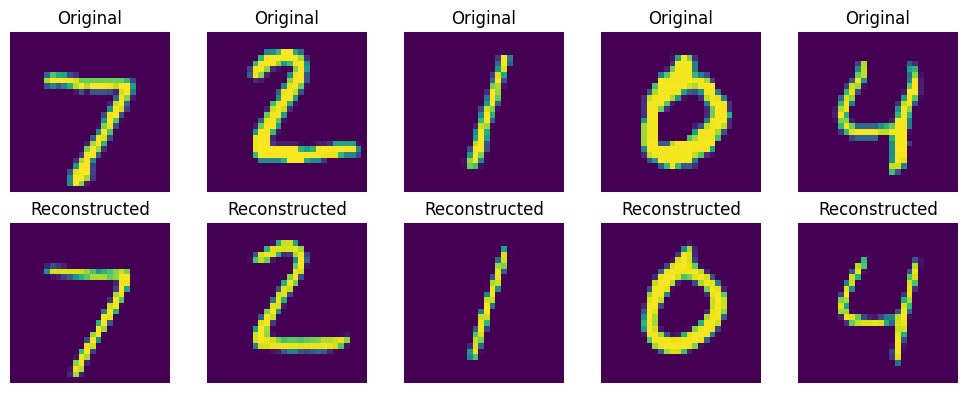

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(DEVICE)

# Predict the reconstructed images
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    reconstructed_images = model(images)

# Move images back to CPU for plotting
images = images.cpu()
reconstructed_images = reconstructed_images.cpu()

# Function to unnormalize and convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Number of images to display
num_images = 5

# Plot the original and reconstructed images
plt.figure(figsize=(10, 4))

for i in range(num_images):
    # Original image
    ax = plt.subplot(2, num_images, i + 1)
    imshow(images[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Plot Latent


(60000, 10)
(60000,)


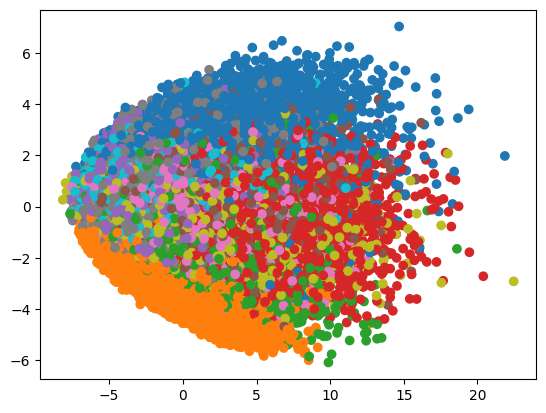

In [ ]:
# Latent Space
latent_spaces = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in train_loader:
    images = images.to(DEVICE)
    latent_space = model.get_latent_space(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)

# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Save the plot
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_PCA.png'
path = './figures/' + name

plot.figure.savefig(path)

# Very Small AE for FMNIST

In [75]:
config = {
    'model_name': 'VerySmall-AE',
    'dataset': 'fMNIST',
    # Variance and Mean for the weight initialization
    'seed': 1
    ,
    # Model setup
    'input_dim': 784,
    # Training setup
    'batch_size': 128,
    'num_epochs': 20,
    'learning_rate': 0.001,
}

# DEVICE for Mac for Windows use CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")
# Set the seed
torch.manual_seed(config['seed'])

Using device cuda


In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
from utils.dataloaders.full_dataloaders import DataLoaderFashionMNIST

# Data Transformations
transformations = [transforms.ToTensor(),
                  # Normalize between -1 and 1
                    transforms.Normalize((0.5,), (0.5,))
                                ]
# Create DataLoader
batch_size = config['batch_size']
dataloader = DataLoaderFashionMNIST(batch_size=batch_size, transformation=transformations)

test_loader = dataloader.get_test_loader()
train_loader = dataloader.get_train_loader()

print(len(train_loader), len(test_loader))

469 79


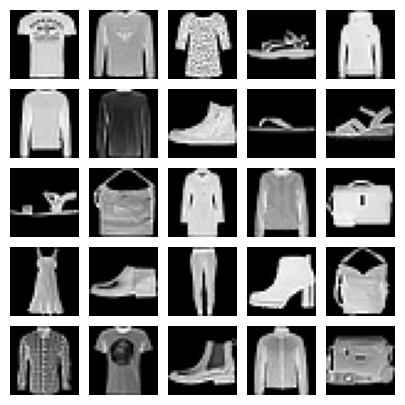

In [78]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)
# Change the shape of the image (Flatten to 2D)
image_org = image[0].view(-1, 1, 28, 28)

num_samples = 25
sample_images = [image_org[i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [79]:
# Model comes from python file for later usage
from models.definitions.ae_latentdim10 import VerySmallAutoencoder
model = VerySmallAutoencoder()
model = model.to(DEVICE)

In [80]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=config['learning_rate'])

for epoch in range(config['num_epochs']):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #x = x.view(config['batch_size'], config['input_dim'])
        x = x.to(DEVICE)

        optimizer.zero_grad()
        loss = model.training_step(x)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


	Epoch 1 complete! 	Average Loss:  0.004891553511604285
	Epoch 2 complete! 	Average Loss:  0.004656192503320292
	Epoch 3 complete! 	Average Loss:  0.004636085045953782
	Epoch 4 complete! 	Average Loss:  0.004625590245486197
	Epoch 5 complete! 	Average Loss:  0.004618534037214505
	Epoch 6 complete! 	Average Loss:  0.004613284376831964
	Epoch 7 complete! 	Average Loss:  0.004609386457536274
	Epoch 8 complete! 	Average Loss:  0.004606084184697232
	Epoch 9 complete! 	Average Loss:  0.004603427569143092
	Epoch 10 complete! 	Average Loss:  0.004601103483508222
	Epoch 11 complete! 	Average Loss:  0.004599249236182206
	Epoch 12 complete! 	Average Loss:  0.004597967310458358
	Epoch 13 complete! 	Average Loss:  0.004596534783108176
	Epoch 14 complete! 	Average Loss:  0.004595386284268183
	Epoch 15 complete! 	Average Loss:  0.00459423488798018
	Epoch 16 complete! 	Average Loss:  0.004593366393859251
	Epoch 17 complete! 	Average Loss:  0.004592881793689588
	Epoch 18 complete! 	Average Loss:  0.004

In [81]:
# Save the model
name = config['dataset']+ '_' + config['model_name'] + '_' + str(model.hidden_dim) + '_' + str(config['seed']) + '.pth'
print(name)
# Model Pathb
path = './models/checkpoints/VerySmallAE/FMNIST/' + name

torch.save(model.state_dict(), path)

fMNIST_VerySmall-AE_10_1.pth


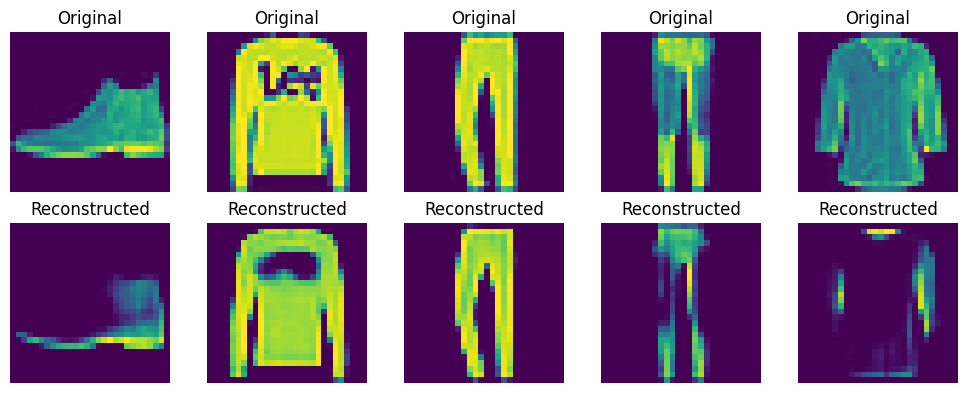

In [82]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(DEVICE)

# Predict the reconstructed images
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    reconstructed_images = model(images)

# Move images back to CPU for plotting
images = images.cpu()
reconstructed_images = reconstructed_images.cpu()

# Function to unnormalize and convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Number of images to display
num_images = 5

# Plot the original and reconstructed images
plt.figure(figsize=(10, 4))

for i in range(num_images):
    # Original image
    ax = plt.subplot(2, num_images, i + 1)
    imshow(images[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

(60000, 10)
(60000,)


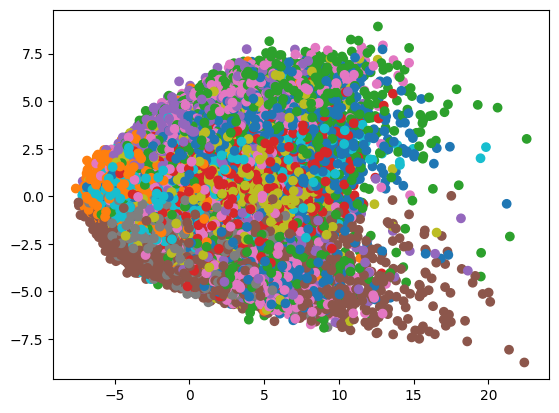

In [83]:
# Latent Space
latent_spaces = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in train_loader:
    images = images.to(DEVICE)
    latent_space = model.get_latent_space(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)

# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Save the plot
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_PCA.png'
path = './figures/' + name

plot.figure.savefig(path)